# Customer segmentation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cluster.cluster_functions import *
from cluster.plotting import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin_min

# sns.set()
%load_ext autoreload
%autoreload 2

In [2]:
invoices = pd.read_csv("data/retail/invoices_2009_2011_no_returns.csv", low_memory=False)
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)

Segmentation is performed on customers who had three or more purchase days in the first year (2009-12-1 : 2010-12-1) whilst the clusters are evaluated on second year purchase days. Three purchase days is just enough to create the aggregation features necessary to cluster on. No information regarding whether a customer's purchase is a repeat purchase is avaiable.  

In [3]:
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]
cohort_invoices[cohort_invoices['CustomerID']==13087.0]  # Print transaction history for Customer 13087

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
26740,491711,85123,WHITE HANGING HEART T-LIGHT HOLDER,18,2009-12-13 15:16:00,2.95,13087.0,United Kingdom,53.10
26741,491711,21463,MIRRORED DISCO BALL,4,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,23.80
26742,491711,85168,WHITE BAROQUE CARRIAGE CLOCK,4,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,39.80
26743,491711,84765,SILVER ROCOCO CANDELABRA,2,2009-12-13 15:16:00,12.75,13087.0,United Kingdom,25.50
26744,491711,22215,CAKE STAND WHITE TWO TIER LACE,2,2009-12-13 15:16:00,8.50,13087.0,United Kingdom,17.00
26745,491711,84750,BLACK SMALL GLASS CAKE STAND,8,2009-12-13 15:16:00,1.95,13087.0,United Kingdom,15.60
26746,491711,22183,CAKE STAND VICTORIAN FILIGREE MED,3,2009-12-13 15:16:00,6.75,13087.0,United Kingdom,20.25
26747,491711,35637,IVORY STRING CURTAIN WITH POLE,2,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,11.90
26748,491711,84707,PINK JEWELLED MIRROR TRINKET TRAY,2,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,19.90
26749,491711,84709,PINK OVAL JEWELLED MIRROR,3,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,17.85


<br>
<br>

# Cluster on RFM features

**KMeans**

In [4]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_time_aggregation_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,21.5,13.435029,12.0,31.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,177.5,4.949747,174.0,181.0,2.0,356.0,357.0,544.590,30.0,928.06
2,12359.0,417.70,231.086670,78.20,760.69,2563.36,6,81.0,45.850845,11.0,110.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,12360.0,502.04,291.890867,118.00,690.79,1310.83,3,131.5,55.861436,92.0,171.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,12361.0,94.20,8.127782,83.15,99.00,276.35,3,109.5,9.192388,103.0,116.0,2.0,220.0,308.0,91.075,1.0,174.90


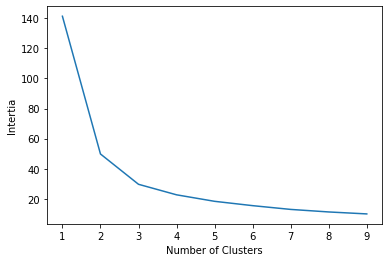

In [5]:
cluster_feature_names = [
    'recency',
    'frequency',
    'monetary_value'   
]
scaler = MinMaxScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)
cluster_elbow_method(cluster_features)

Inertia for 3 clusters: 29.634516591432224
Cluster labels - 0 = Low value customer, 2 = High value customer
Silhouette Coefficient:0.8769330158063914
Median 2nd year RLV: [ 858.42  547.12 1844.02]
Differences: [311.3, 1296.9]
Value Counts:
0    696
1    454
2    749
Name: Cluster, dtype: int64
Explained variance ratio: [0.89842138 0.05825198]
Total explained variance: 0.9566733587534938


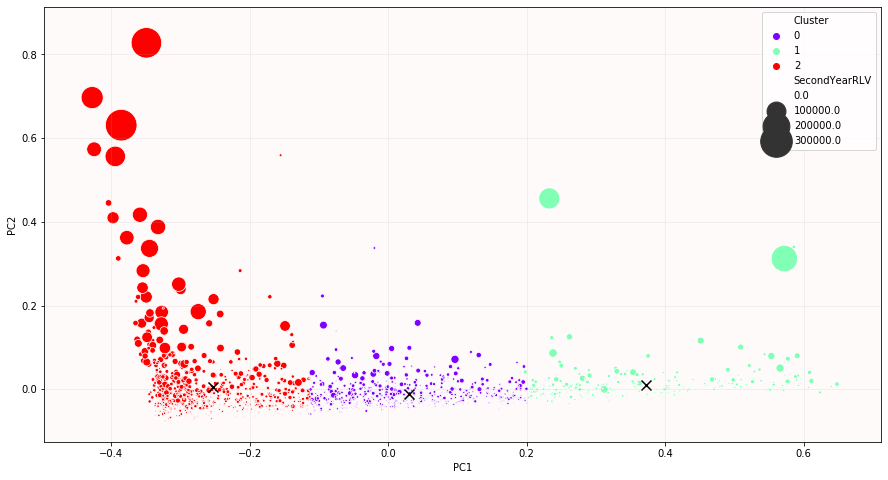

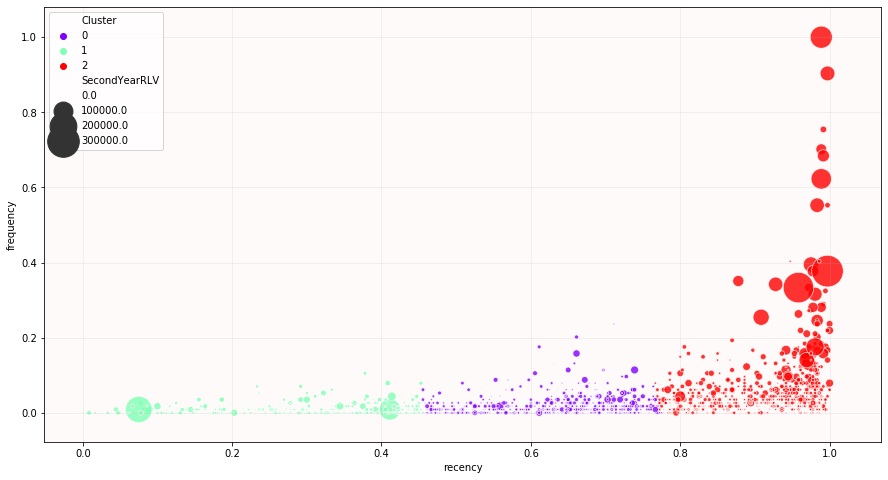

In [6]:
num_clusters = 3
cluster_features, cluster_centers  = perform_km_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [7]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=cluster_feature_names,
    index=['Component 1', 'Component 2']
)

,recency,frequency,monetary_value
Component 1,-0.994995,-0.097647,-0.021201
Component 2,-0.082719,0.685911,0.722968


**GMM**

In [8]:
cluster_feature_names = [
    'recency',
    'frequency',
    'monetary_value'   
]
scaler = MinMaxScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Cluster labels - 0 = Low value customer, 2 = High value customer
Silhouette Coefficient:0.7486899489680416
Median 2nd year RLV: [ 498.95 1592.06 5655.91]
Differences: [1093.11, 4063.85]
Value Counts:
0    899
1    799
2    201
Name: Cluster, dtype: int64
Explained variance ratio: [0.89842138 0.05825198]
Total explained variance: 0.9566733587534938


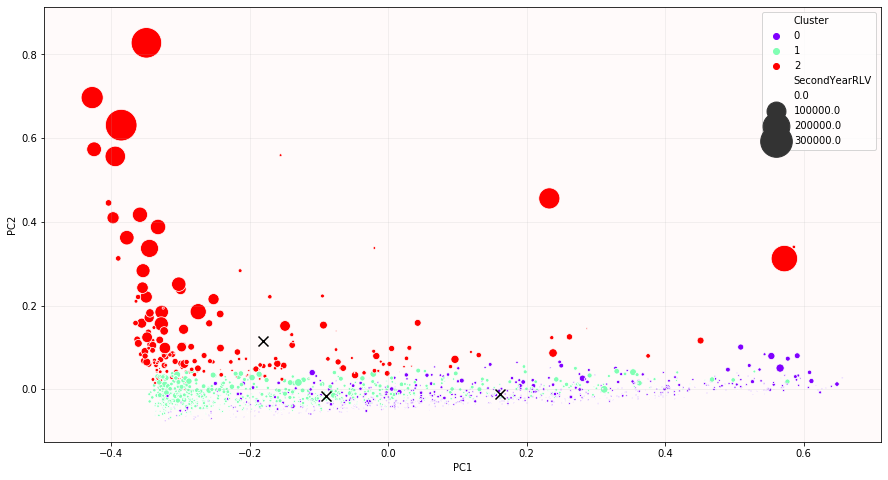

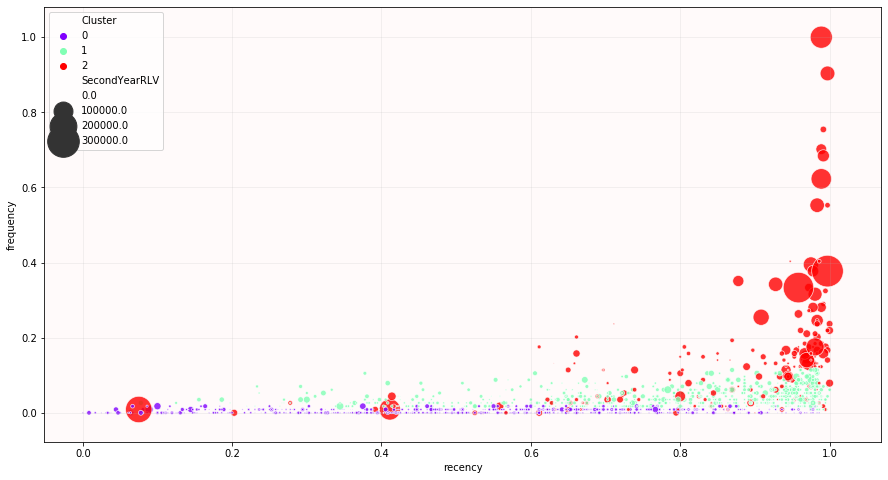

In [9]:
num_clusters = 3
cluster_features, cluster_centers, _  = perform_gmm_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [10]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=cluster_feature_names,
    index=['Component 1', 'Component 2']
)

,recency,frequency,monetary_value
Component 1,-0.994995,-0.097647,-0.021201
Component 2,-0.082719,0.685911,0.722968


<br>
<br>

# Cluster on aggregation features

**KMeans**

In [11]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_time_aggregation_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,21.5,13.435029,12.0,31.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,177.5,4.949747,174.0,181.0,2.0,356.0,357.0,544.590,30.0,928.06
2,12359.0,417.70,231.086670,78.20,760.69,2563.36,6,81.0,45.850845,11.0,110.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,12360.0,502.04,291.890867,118.00,690.79,1310.83,3,131.5,55.861436,92.0,171.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,12361.0,94.20,8.127782,83.15,99.00,276.35,3,109.5,9.192388,103.0,116.0,2.0,220.0,308.0,91.075,1.0,174.90


In [12]:
features_to_transform = [
    'MedianPurchaseValue',
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue',
    'SizePurchaseValue',
    'MedianTimeBetweenPurchase',
    'StDevTimeBetweenPurchase',
    'MinTimeBetweenPurchase',
    'MaxTimeBetweenPurchase',
]
features, transformed_feature_names, yjt = transform_features(features, features_to_transform, transform="yjt")
features.head()

,yjt_MedianPurchaseValue,yjt_StDevPurchaseValue,yjt_MinPurchaseValue,yjt_MaxPurchaseValue,yjt_SumPurchaseValue,yjt_SizePurchaseValue,yjt_MedianTimeBetweenPurchase,yjt_StDevTimeBetweenPurchase,yjt_MinTimeBetweenPurchase,yjt_MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,5.789114,5.365618,15.644784,3.224589,3.705797,0.706056,4.810429,3.379806,3.223952,7.144626,12356.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,5.809899,5.132718,14.216121,3.181008,3.669940,0.706056,11.021725,2.083714,8.320107,16.214547,12358.0,2.0,356.0,357.0,544.590,30.0,928.06
2,5.300495,4.525551,8.895903,3.084534,3.672903,0.794942,8.287425,5.433585,3.100379,13.005773,12359.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,5.440558,4.682928,10.459276,3.068304,3.550225,0.706056,9.907941,5.812600,6.863877,15.816835,12360.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,4.127572,2.048027,9.117004,2.634365,3.182981,0.706056,9.270728,2.847447,7.109999,13.319642,12361.0,2.0,220.0,308.0,91.075,1.0,174.90


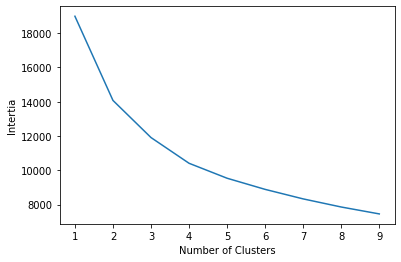

In [13]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)
cluster_elbow_method(cluster_features)

Inertia for 4 clusters: 10412.561951172123
Cluster labels - 0 = Low value customer, 3 = High value customer
Silhouette Coefficient:0.2500868363320461
Median 2nd year RLV: [ 325.91 1140.21 1255.   5063.9 ]
Differences: [814.3, 114.79, 3808.9]
Value Counts:
0    483
1    579
2    517
3    320
Name: Cluster, dtype: int64
Explained variance ratio: [0.41830064 0.2769082 ]
Total explained variance: 0.6952088410642034


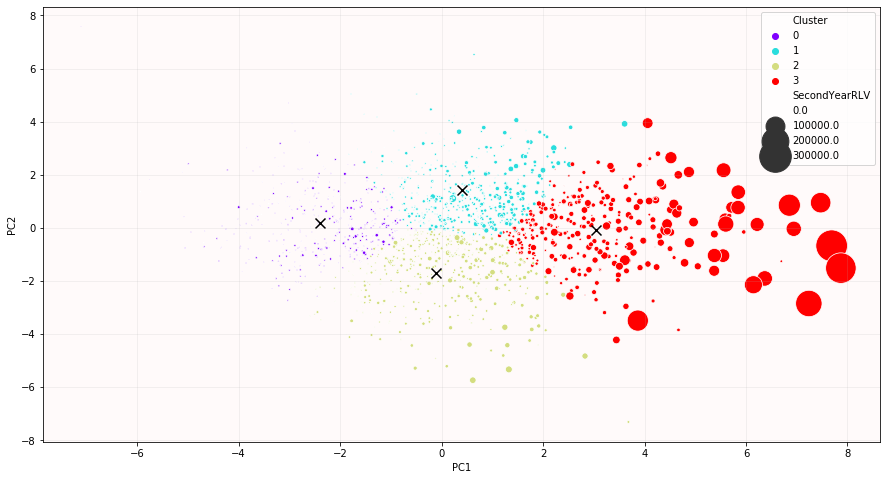

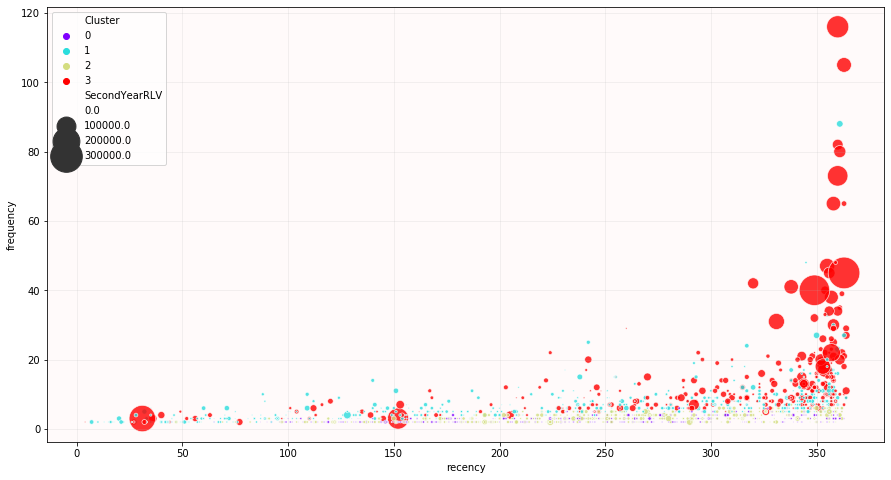

In [14]:
num_clusters = 4
cluster_features, cluster_centers  = perform_km_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [15]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase
Component 1,0.297597,0.337401,0.069660,0.389678,0.446685,0.344361,-0.330561,-0.238875,-0.280295,-0.279081
Component 2,-0.415640,-0.252700,-0.411593,-0.327157,-0.168908,0.228350,-0.365923,-0.260104,-0.308154,-0.331299


**Pareto**

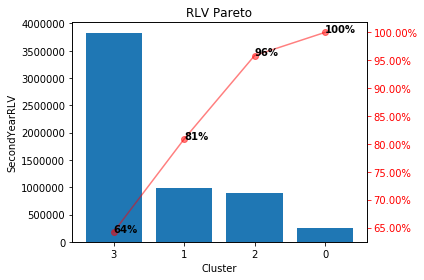

In [16]:
pareto_df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)
pareto_plot(pareto_df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

**Mean Cluster Features**

In [17]:
features_copy = features.copy()

# Inverse transform to see cluster features
if yjt:
    features_copy.drop(columns=transformed_feature_names, inplace=True)
    features_copy = pd.concat([
        pd.DataFrame(yjt.inverse_transform(features[transformed_feature_names]), columns=features_to_transform),
        features_copy
    ], axis=1)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
else:
    for transf_col, col in zip(transformed_feature_names, features_to_transform):
        features_copy[transf_col] = np.exp(features_copy[transf_col]) - 1
        features_copy.rename(columns={transf_col:col}, inplace=True)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
features_copy.groupby("Cluster").mean()

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
Cluster,,,,,,,,,,,,,,,,,
0,208.172060,82.322193,137.499503,308.188965,792.697433,3.720497,84.276398,62.919943,41.215321,146.354037,15558.103520,2.720497,233.157350,284.484472,215.942406,84.627329,512.288302
1,255.832945,126.163182,128.072902,467.870846,2025.594231,7.709845,30.072539,23.319824,11.227979,70.526770,15471.110535,6.709845,215.951641,257.663212,265.578498,85.863558,1713.898325
2,555.871789,278.475157,335.813694,943.311973,2449.732476,4.156673,77.682785,50.547314,41.984526,133.510638,15052.976789,3.156673,246.557060,294.694391,597.179779,85.924565,1725.362360
3,750.013578,707.500785,237.042656,2563.385406,13565.007969,14.390625,24.668750,20.394218,6.556250,66.346875,15193.562500,13.390625,283.556250,311.428125,887.875786,82.393750,11960.261406


**Typical Customer**

In [18]:
closest, _ = pairwise_distances_argmin_min(cluster_centers, cluster_features[transformed_feature_names])
features_copy.iloc[closest]

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV,Cluster
1426,221.940,62.744761,105.05,240.00,788.93,4.0,89.0,50.477718,27.0,127.0,16784.0,3.0,245.0,247.0,192.820000,36.0,107.60,0
592,214.165,123.905543,76.15,416.60,1293.61,6.0,22.0,26.602631,9.0,73.0,14217.0,5.0,151.0,153.0,175.402000,13.0,2004.98,1
1707,412.620,205.125823,302.90,767.05,1895.19,4.0,63.0,48.675798,29.0,125.0,17667.0,3.0,219.0,280.0,480.163333,15.0,2055.51,2
883,508.640,402.633526,175.20,1575.98,9105.36,14.0,27.0,15.864005,2.0,53.0,15093.0,13.0,343.0,357.0,681.209231,7.0,4597.02,3


In [19]:
typical_customers = features.iloc[closest].CustomerID.values
daily_customer_revenues = cohort_invoices.groupby(["CustomerID", pd.Grouper(key='InvoiceDate', freq='D')])['Revenue'].sum().reset_index()
for customer in typical_customers:
    print(daily_customer_revenues[daily_customer_revenues.CustomerID==customer].to_string(index=False))
    print()

 CustomerID InvoiceDate  Revenue
    16784.0  2010-03-28   210.47
    16784.0  2010-08-03   105.05
    16784.0  2010-10-31   240.00
    16784.0  2010-11-28   233.41
    16784.0  2011-11-20   107.60

 CustomerID InvoiceDate  Revenue
    14217.0  2010-06-30   416.60
    14217.0  2010-08-05   272.48
    14217.0  2010-10-18   226.90
    14217.0  2010-11-09   201.43
    14217.0  2010-11-19    76.15
    14217.0  2010-11-28   100.05
    14217.0  2010-12-08   118.30
    14217.0  2011-01-07   102.50
    14217.0  2011-01-11    69.70
    14217.0  2011-02-01    88.30
    14217.0  2011-03-20   130.05
    14217.0  2011-04-08   112.80
    14217.0  2011-05-16   202.24
    14217.0  2011-06-08   165.36
    14217.0  2011-07-07    95.75
    14217.0  2011-09-01   126.50
    14217.0  2011-09-26   258.17
    14217.0  2011-10-13   102.95
    14217.0  2011-10-30    92.52
    14217.0  2011-11-15   105.76
    14217.0  2011-11-28   139.60
    14217.0  2011-12-08    94.48

 CustomerID InvoiceDate  Revenue
    1766

**GMM**

In [20]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Cluster labels - 0 = Low value customer, 3 = High value customer
Silhouette Coefficient:0.10293014450782464
Median 2nd year RLV: [ 460.95   559.51  1461.395 2202.99 ]
Differences: [98.56, 901.88, 741.6]
Value Counts:
0    494
1    194
2    726
3    485
Name: Cluster, dtype: int64
Explained variance ratio: [0.41830064 0.2769082 ]
Total explained variance: 0.6952088410642037


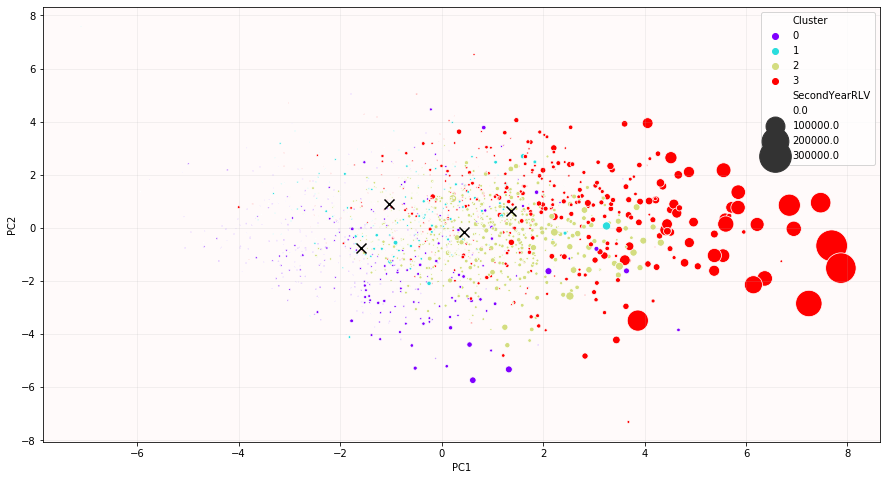

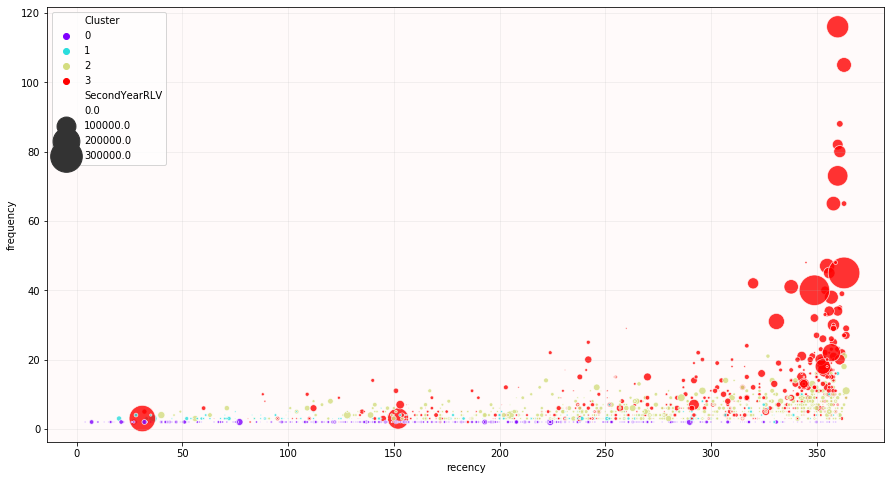

In [21]:
num_clusters = 4
cluster_features, cluster_centers, _  = perform_gmm_clustering(cluster_features, num_clusters)
cluster_features, cluster_centers = reorder_clusters(cluster_features, cluster_centers, features, num_clusters)
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [22]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase
Component 1,0.297597,0.337401,0.069660,0.389678,0.446685,0.344361,-0.330561,-0.238875,-0.280295,-0.279081
Component 2,-0.415640,-0.252700,-0.411593,-0.327157,-0.168908,0.228350,-0.365923,-0.260104,-0.308154,-0.331299


**Pareto**

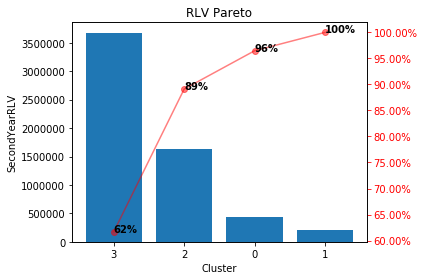

In [23]:
pareto_df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
pareto_df['Cluster'] = pareto_df['Cluster'].astype(str)
pareto_plot(pareto_df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

**Mean Cluster Features**

In [24]:
features_copy = features.copy()

# Inverse transform to see cluster features
if yjt:
    features_copy.drop(columns=transformed_feature_names, inplace=True)
    features_copy = pd.concat([
        pd.DataFrame(yjt.inverse_transform(features[transformed_feature_names]), columns=features_to_transform),
        features_copy
    ], axis=1)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
else:
    for transf_col, col in zip(transformed_feature_names, features_to_transform):
        features_copy[transf_col] = np.exp(features_copy[transf_col]) - 1
        features_copy.rename(columns={transf_col:col}, inplace=True)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
features_copy.groupby("Cluster").mean()

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
Cluster,,,,,,,,,,,,,,,,,
0,377.485081,173.383981,253.377470,583.002530,1213.865081,3.000000,90.088057,52.974322,52.629555,127.546559,15238.107287,2.000000,181.155870,245.056680,401.897045,80.597166,887.439028
1,274.536701,66.319348,203.187526,356.956907,1278.882010,4.644330,52.115979,27.925843,29.685567,85.185567,15653.798969,3.644330,193.077320,249.324742,274.426417,91.963918,1084.037938
2,393.337397,189.043927,223.977810,732.646185,2839.356309,6.603306,48.500000,34.269678,21.657025,100.183196,15309.877410,5.603306,267.217631,301.119835,419.208800,85.633609,2251.899091
3,517.038639,510.141192,129.569196,1729.018742,8770.888701,12.037113,33.708247,41.412180,5.630928,102.088660,15334.501031,11.037113,278.167010,310.447423,607.857475,85.676289,7578.353381


<br>
<br>

## Why transform?

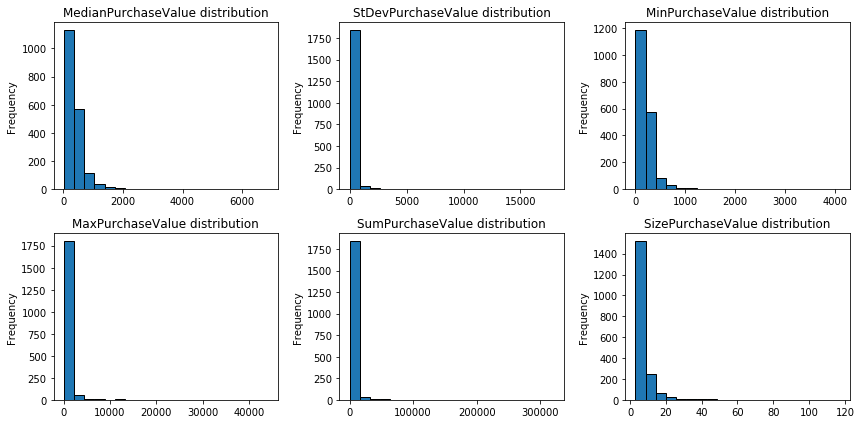

In [25]:
cluster = 0
fig = plt.figure(figsize=(12,6))
for idx, feat in enumerate(features_to_transform[:6]):
    ax = fig.add_subplot(2,3,idx+1)
    features_copy[feat].plot.hist(bins=20, ax=ax, edgecolor='k')
    ax.set_title(f"{feat} distribution")
plt.tight_layout()

Before transformation, all monetary aggregation features are right skewed. This exaggerates the difference between the highest spending customers and those who are relatively high spenders but don't spend as much. The clustering algorithms won't group these customers together unless the right side of the axis is "squashed" together which the transform seeks to achieve.